In [2]:
import numpy as np 

In [38]:
import pandas as pd 

from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import os
from collections import Counter
import math

import tensorflow as tf
from tensorflow.keras.layers import Flatten, Dropout, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from tensorflow.keras import backend as K

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn import metrics
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score, roc_auc_score,roc_curve, f1_score

from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.utils.class_weight import compute_class_weight
from keras.utils import plot_model
from sklearn.manifold import TSNE
from scipy.stats import randint, uniform
sns.set_style("whitegrid")

In [39]:
x_bal = np.load('x_balanced.npy')
y_bal = np.load('y_balanced.npy', allow_pickle=True)

unique_values  [False]
counts  [8502000]


/home/vivek/Documents/CS725/Project/venv/lib/python3.11/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/vivek/Documents/CS725/Project/venv/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


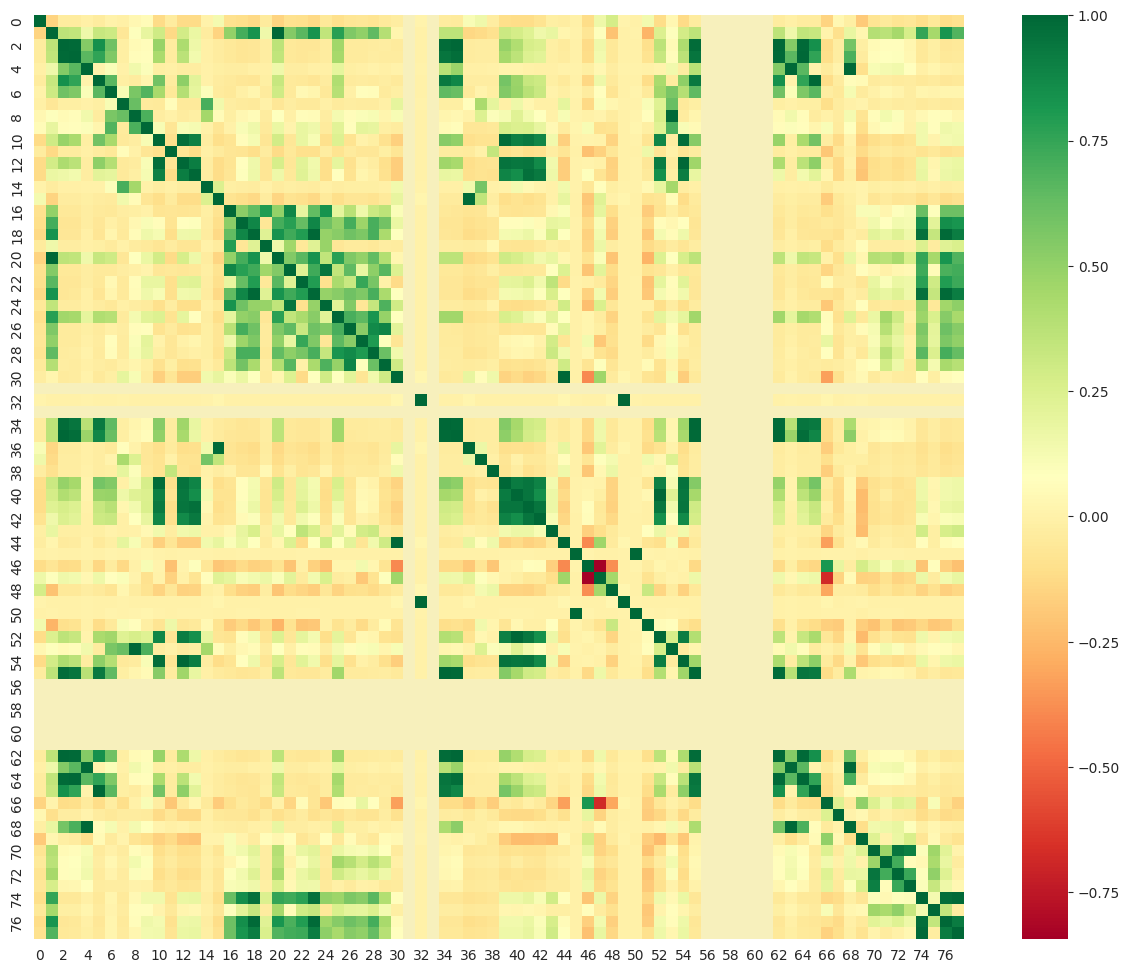

In [63]:
# Calculate the correlation matrix for all columns
correlation_matrix = np.corrcoef(x_bal, rowvar=False)

plt.figure(figsize =(15, 12)) 
color = plt.get_cmap('RdYlGn')   # default color
color.set_bad('#f7f0bc')
sns.heatmap(correlation_matrix, cmap=color) 

plt.savefig('feature_heatmap.png')

[[ 1.         -0.15139241 -0.03639181 ... -0.05808656 -0.11371651
  -0.09402542]
 [-0.15139241  1.          0.36250607 ...  0.44057258  0.82454523
   0.68200214]
 [-0.03639181  0.36250607  1.         ... -0.01774823 -0.05870305
  -0.05340805]
 ...
 [-0.05808656  0.44057258 -0.01774823 ...  1.          0.34078943
  -0.02931417]
 [-0.11371651  0.82454523 -0.05870305 ...  0.34078943  1.
   0.92519925]
 [-0.09402542  0.68200214 -0.05340805 ... -0.02931417  0.92519925
   1.        ]]


In [10]:
x_corr = np.load('x_corr.npy')
y_corr = np.load('y_corr.npy', allow_pickle=True)
print(f"X shape {x_corr} y shape {y_corr}")

X shape [[5.30000000e+01 6.28740000e+04 4.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [5.72250000e+04 8.60000000e+01 1.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [8.00000000e+01 1.16003861e+08 1.60000000e+01 ... 3.12550977e+04
  1.40678000e+05 1.48920010e+04]
 ...
 [4.44000000e+02 1.19299621e+08 2.80500000e+03 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [4.44000000e+02 1.19296592e+08 2.79700000e+03 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [4.44000000e+02 2.47196670e+07 5.90000000e+02 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]] y shape ['BENIGN' 'BENIGN' 'BENIGN' ... 'Heartbleed' 'Heartbleed' 'Heartbleed']


## Modifying The code for correlation coefficient

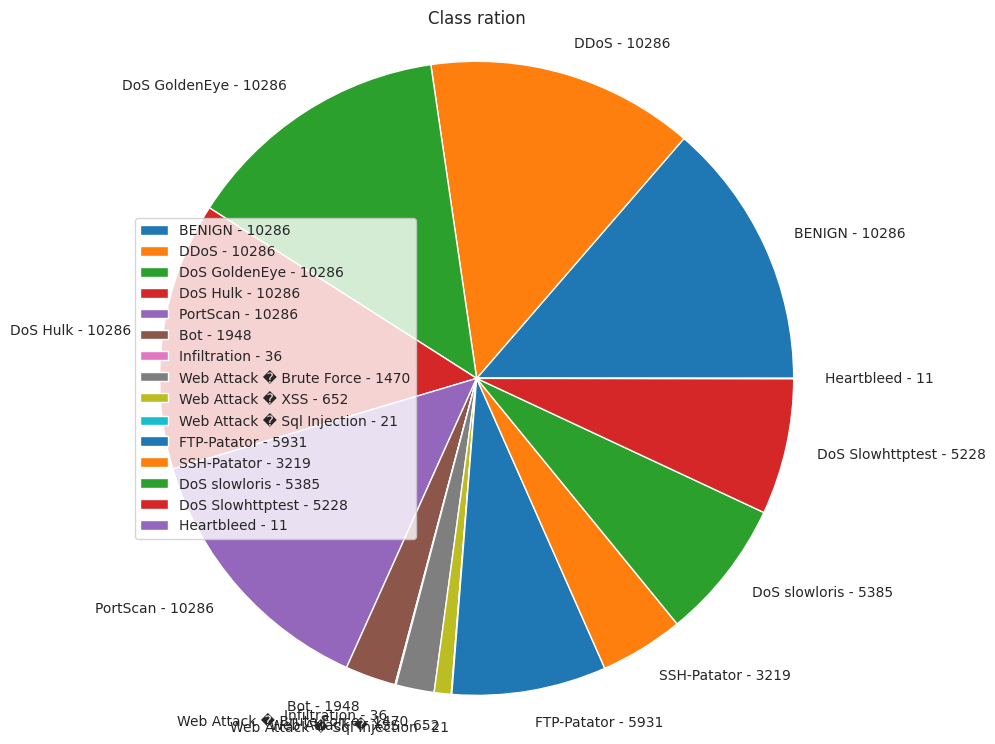

In [11]:
sizes=[]
labels=[]

for i in Counter(y_corr):
    tmp=str(i)+' - '+str(Counter(y_corr)[i])
    labels.append(tmp)
    sizes.append(Counter(y_corr)[i])
    
fig1, ax1 = plt.subplots(figsize = (9, 9))
ax1.pie(sizes,  labels = labels)
ax1.axis('equal')
plt.title('Class ration')
plt.legend()
plt.show()

In [14]:
x_scaled = StandardScaler().fit_transform(x_corr)

x_train, x_test, y_train, y_test = train_test_split(x_scaled,y_corr,test_size=0.2,random_state=42, stratify=y_corr)

print('===========x_train=============', x_train.shape)
print('===========x_test==============', x_test.shape)

===========x_train============= (60264, 43)
===========x_test============== (15067, 43)


In [15]:
labels=np.unique(y_train)

classes = []
for i in range(0,len(labels)):
    classes.append(i)

map=dict(zip(labels,classes))
print(map)

y_train_class=[]
for i in range(0, len(y_train)):
    y_train_class.append(map[y_train[i]])
y_train=np.asarray(y_train_class)


'''Test sample processing'''

y_test_class=[]
for i in range(0, len(y_test)):
    y_test_class.append(map[y_test[i]])    
y_test=np.asarray(y_test_class)

{'BENIGN': 0, 'Bot': 1, 'DDoS': 2, 'DoS GoldenEye': 3, 'DoS Hulk': 4, 'DoS Slowhttptest': 5, 'DoS slowloris': 6, 'FTP-Patator': 7, 'Heartbleed': 8, 'Infiltration': 9, 'PortScan': 10, 'SSH-Patator': 11, 'Web Attack � Brute Force': 12, 'Web Attack � Sql Injection': 13, 'Web Attack � XSS': 14}


In [16]:
del x_scaled,x_corr,y_corr
!free

               total        used        free      shared  buff/cache   available
Mem:         3912944     3328760      110412      337096     1086716      584184
Swap:       10485756     1825120     8660636


In [18]:
input_layer = Input(shape=(43,))

branch1 = Dense(64, activation='relu')(input_layer)
branch1 = Dense(32, activation='relu')(branch1)

branch2 = Dense(256, activation='relu')(input_layer)
branch2 = Dropout(0.2)(branch2)
branch2 = Dense(64)(branch2) 
#branch2 = Dropout(0.2)(branch2)
branch2 = Dense(32, activation='relu')(branch2)

branch3 = Dense(512, activation='relu')(input_layer)
branch3 = Dense(128, activation='relu')(branch3)
branch3 = Dense(32, activation='relu')(branch3)

merged = tf.keras.layers.concatenate([branch1, branch2, branch3])

output_layer = Dense(15, activation='softmax')(merged)
model = Model(inputs=input_layer, outputs=output_layer) 

model.compile(optimizer=Adam(learning_rate=0.0006),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

class_weights = compute_class_weight(class_weight = "balanced", classes = np.unique(y_train), y = y_train) 
class_weights = dict(zip(np.unique(y_train), class_weights))

history = model.fit(x_train, y_train, validation_x_bal=(x_test, y_test), epochs=50, batch_size=100)

model.summary()
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=False)

Epoch 1/50
603/603 [==============================] - 7s 7ms/step - loss: 0.3782 - accuracy: 0.8994 - val_loss: 0.1755 - val_accuracy: 0.9551
Epoch 2/50
603/603 [==============================] - 4s 7ms/step - loss: 0.1440 - accuracy: 0.9582 - val_loss: 0.1342 - val_accuracy: 0.9642
Epoch 3/50
603/603 [==============================] - 4s 7ms/step - loss: 0.1172 - accuracy: 0.9642 - val_loss: 0.1059 - val_accuracy: 0.9683
Epoch 4/50
603/603 [==============================] - 4s 7ms/step - loss: 0.1030 - accuracy: 0.9676 - val_loss: 0.1030 - val_accuracy: 0.9697
Epoch 5/50
603/603 [==============================] - 4s 7ms/step - loss: 0.0990 - accuracy: 0.9700 - val_loss: 0.0945 - val_accuracy: 0.9737
Epoch 6/50
603/603 [==============================] - 5s 8ms/step - loss: 0.0892 - accuracy: 0.9717 - val_loss: 0.0890 - val_accuracy: 0.9719
Epoch 7/50
603/603 [==============================] - 5s 8ms/step - loss: 0.0858 - accuracy: 0.9728 - val_loss: 0.0867 - val_accuracy: 0.9736
Epoch 

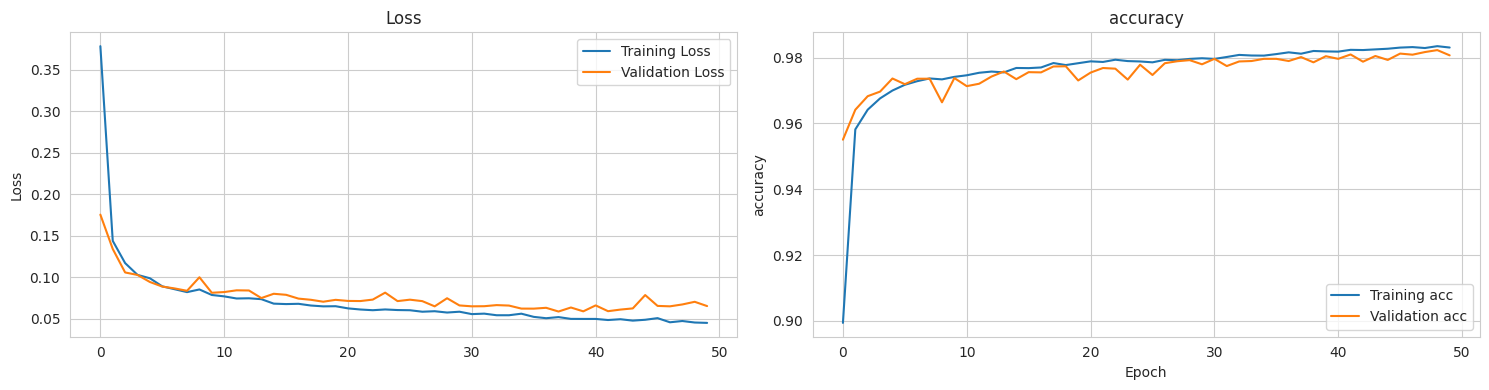

In [19]:
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 1)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.title('Loss')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(acc, label='Training acc')
plt.plot(val_acc, label='Validation acc')
plt.legend()
plt.title('accuracy')
plt.xlabel('Epoch')
plt.ylabel('accuracy')

plt.tight_layout()
plt.show()

In [21]:
def show_result(y_true,y_pred):
    """Outputs a classification report and error matrix"""
    print(classification_report(y_true,y_pred))
    plt.figure(figsize = (10,8))
    sns.heatmap(metrics.confusion_matrix(y_true, y_pred), annot = True, fmt = 'd', cmap='crest')
    plt.title('Confusion Matrix')
    plt.ylabel('Actual Values')
    plt.xlabel('Predicted Values')
    plt.show()

471/471 [==============================] - 1s 2ms/step


/home/vivek/Documents/CS725/Project/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/vivek/Documents/CS725/Project/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/vivek/Documents/CS725/Project/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

              precision    recall  f1-score   support

           0       0.98      0.97      0.97      2057
           1       0.94      0.99      0.97       390
           2       1.00      1.00      1.00      2057
           3       0.99      1.00      0.99      2057
           4       1.00      0.99      0.99      2058
           5       0.99      0.99      0.99      1046
           6       1.00      0.99      0.99      1077
           7       1.00      1.00      1.00      1186
           8       1.00      1.00      1.00         2
           9       0.44      0.57      0.50         7
          10       1.00      1.00      1.00      2057
          11       0.97      0.99      0.98       644
          12       0.67      0.95      0.78       294
          13       0.00      0.00      0.00         4
          14       0.50      0.01      0.02       131

    accuracy                           0.98     15067
   macro avg       0.83      0.83      0.81     15067
weighted avg       0.98   

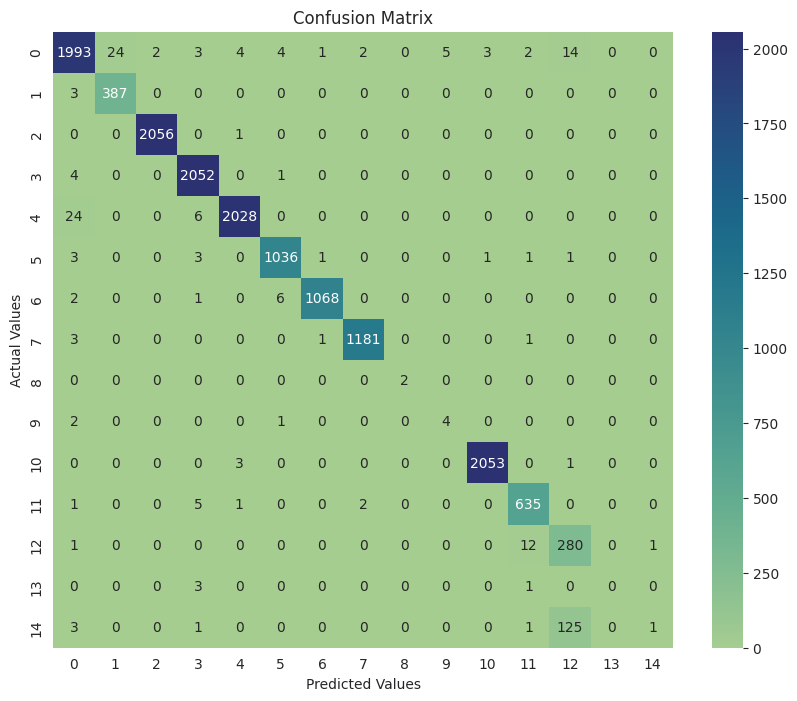

In [22]:
tmp=model.predict(x_test)

pred=[]
for i in range(0,len(tmp)):
    max=np.amax(tmp[i])
    for k in range(0,len(tmp[i])):
        if (tmp[i][k]==max):
            pred.append(k)
preds=np.asarray(pred)

show_result(y_test,preds)

In [23]:
f_score_1, f_score_2, f_score_3 = 0.97, 0.97, 0.89
mean_f=((f_score_1+f_score_2+f_score_3)/3)*100
print('F-measures obtained during training:', f_score_1, f_score_2, f_score_3)
print('Average F-measure', (f_score_1+f_score_2+f_score_3)/3)

res = min(math.floor(mean_f-71),22)
if(res<0): res=0

print('Number of points:', res)

F-measures obtained during training: 0.97 0.97 0.89
Average F-measure 0.9433333333333334
Number of points: 22


In [35]:
def calculate_metrics(y_true, y_pred):

    # Calculate accuracy
    accuracy = accuracy_score(y_true, y_pred)

    # Calculate F1 score (assuming it's a binary classification, change average parameter for multiclass)
    f1 = f1_score(y_true, y_pred, average='macro')

    return accuracy, f1

In [36]:
from scipy.special import softmax

In [37]:
logits = model.predict(x_test)
probabilities = softmax(logits, axis=-1)
y_pred = np.argmax(probabilities, axis=-1)


accuracy, f1 = calculate_metrics(y_test, y_pred)

print(f'Test Accuracy: {accuracy:.4f}')
print(f'F1 Score: {f1:.4f}')

471/471 [==============================] - 1s 3ms/step
Test Accuracy: 0.9807
F1 Score: 0.8119


## Accuracy and F1_score plot

In [89]:
models = [ 'KNN', 'Logistic Regression', 'FFNN', 'Multi-headed NN', 'Random Forest', 'XGBoost', 'Adaboost']
accuracy_values = [ 0.97, 0.76, 0.96, 0.9807, 0.99, 0.98, 0.98]
f1_macro = [ 0.97, 0.764, 0.9619, 0.98, 0.9807, 1.00, 0.99]
f1_micro = [ 0.97, 0.738, 0.8949, 0.8119, 0.98, 1.00, 0.96]

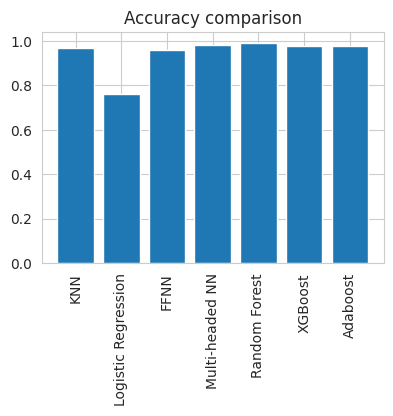

In [90]:
f = plt.figure(figsize =(15, 3), num = 10) 
plt.subplot(131) 
plt.title('Accuracy comparison')
plt.xticks(rotation='vertical')
plt.bar(models, accuracy_values) 
plt.savefig('Accuracy_plot.png')

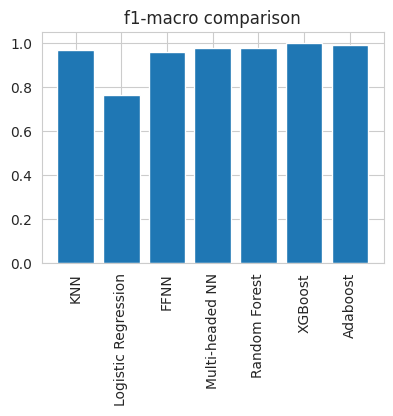

In [101]:
f = plt.figure(figsize =(15, 3), num = 10) 
plt.subplot(131) 
plt.title('f1-macro comparison')
plt.xticks(rotation='vertical')
plt.bar(models, f1_macro) 
plt.savefig('f1_macro_plot.png')

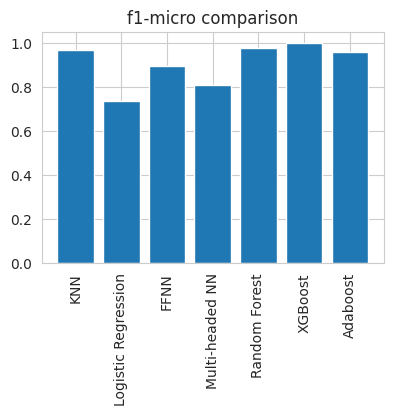

In [103]:
f = plt.figure(figsize =(15, 3), num = 10) 
plt.subplot(131) 
plt.title('f1-micro comparison')
plt.xticks(rotation='vertical')
plt.bar(models, f1_micro) 
plt.savefig('f1_micro_plot.png')